In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
# f_true = 0.534
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

species = ['y']
parameters = {'m':m_true, 'b': b_true}
rule = ('assignment',{'equation':'y = _m*t + _b'})
x0 = {'y':0}
M = Model(species = species, parameters = parameters, rules = [rule], initial_condition_dict = x0)


#Simulate the Model deterministically
x0 = np.linspace(0, 10, 50)
results_det = py_simulate_model(x0, Model = M) #Returns a Pandas DataFrame


## Generate artificial data 

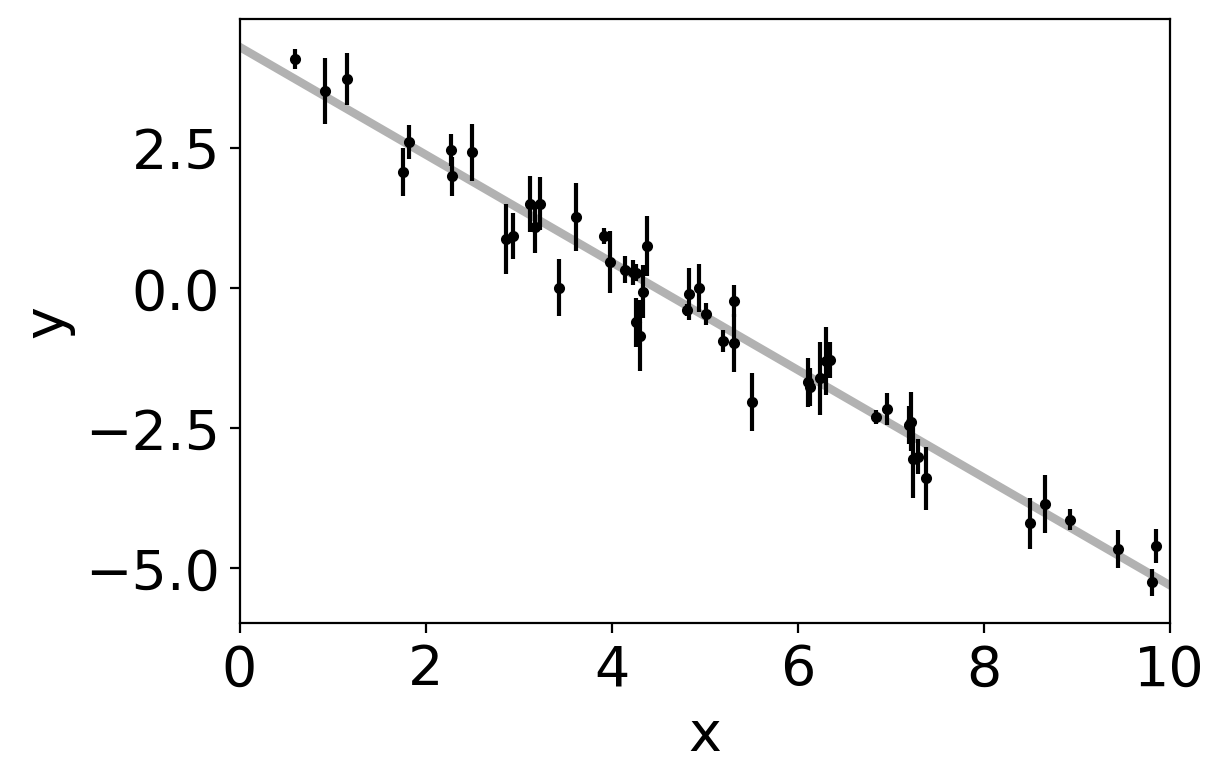

In [3]:

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.6 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 50)
plt.plot(x0, results_det['y'], "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

In [4]:
import pandas as pd
exp_data = pd.DataFrame()
exp_data['x'] = x0
exp_data['y'] = y
# exp_data

In [14]:
# from bioscrape.pid_interfaces import 
from bioscrape.emcee_interface import initialize_mcmc

# Import data from CSV
# Import a CSV file for each experiment run
pid = initialize_mcmc()
pid.M = M
pid.exp_data = exp_data
# data_list.append(list(data.get('X')))
# pid.exp_data = np.array(data_list)
pid.measurements = ['y']
pid.time_column = ['x']
# -50.0 < m < 50 and -110.0 < b < 110.0:
pid.prior = {'m' : ['uniform', -500, 500],'b' : ['uniform', -1000, 1000]}
pid.params_to_estimate = ['m', 'b']
pid.nwalkers = 320
pid.init_seed = 1e-4
pid.nsteps = 2000
pid.type = 'deterministic'

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:52<00:00, 38.10it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file
Parameter posterior distribution convergence plots:


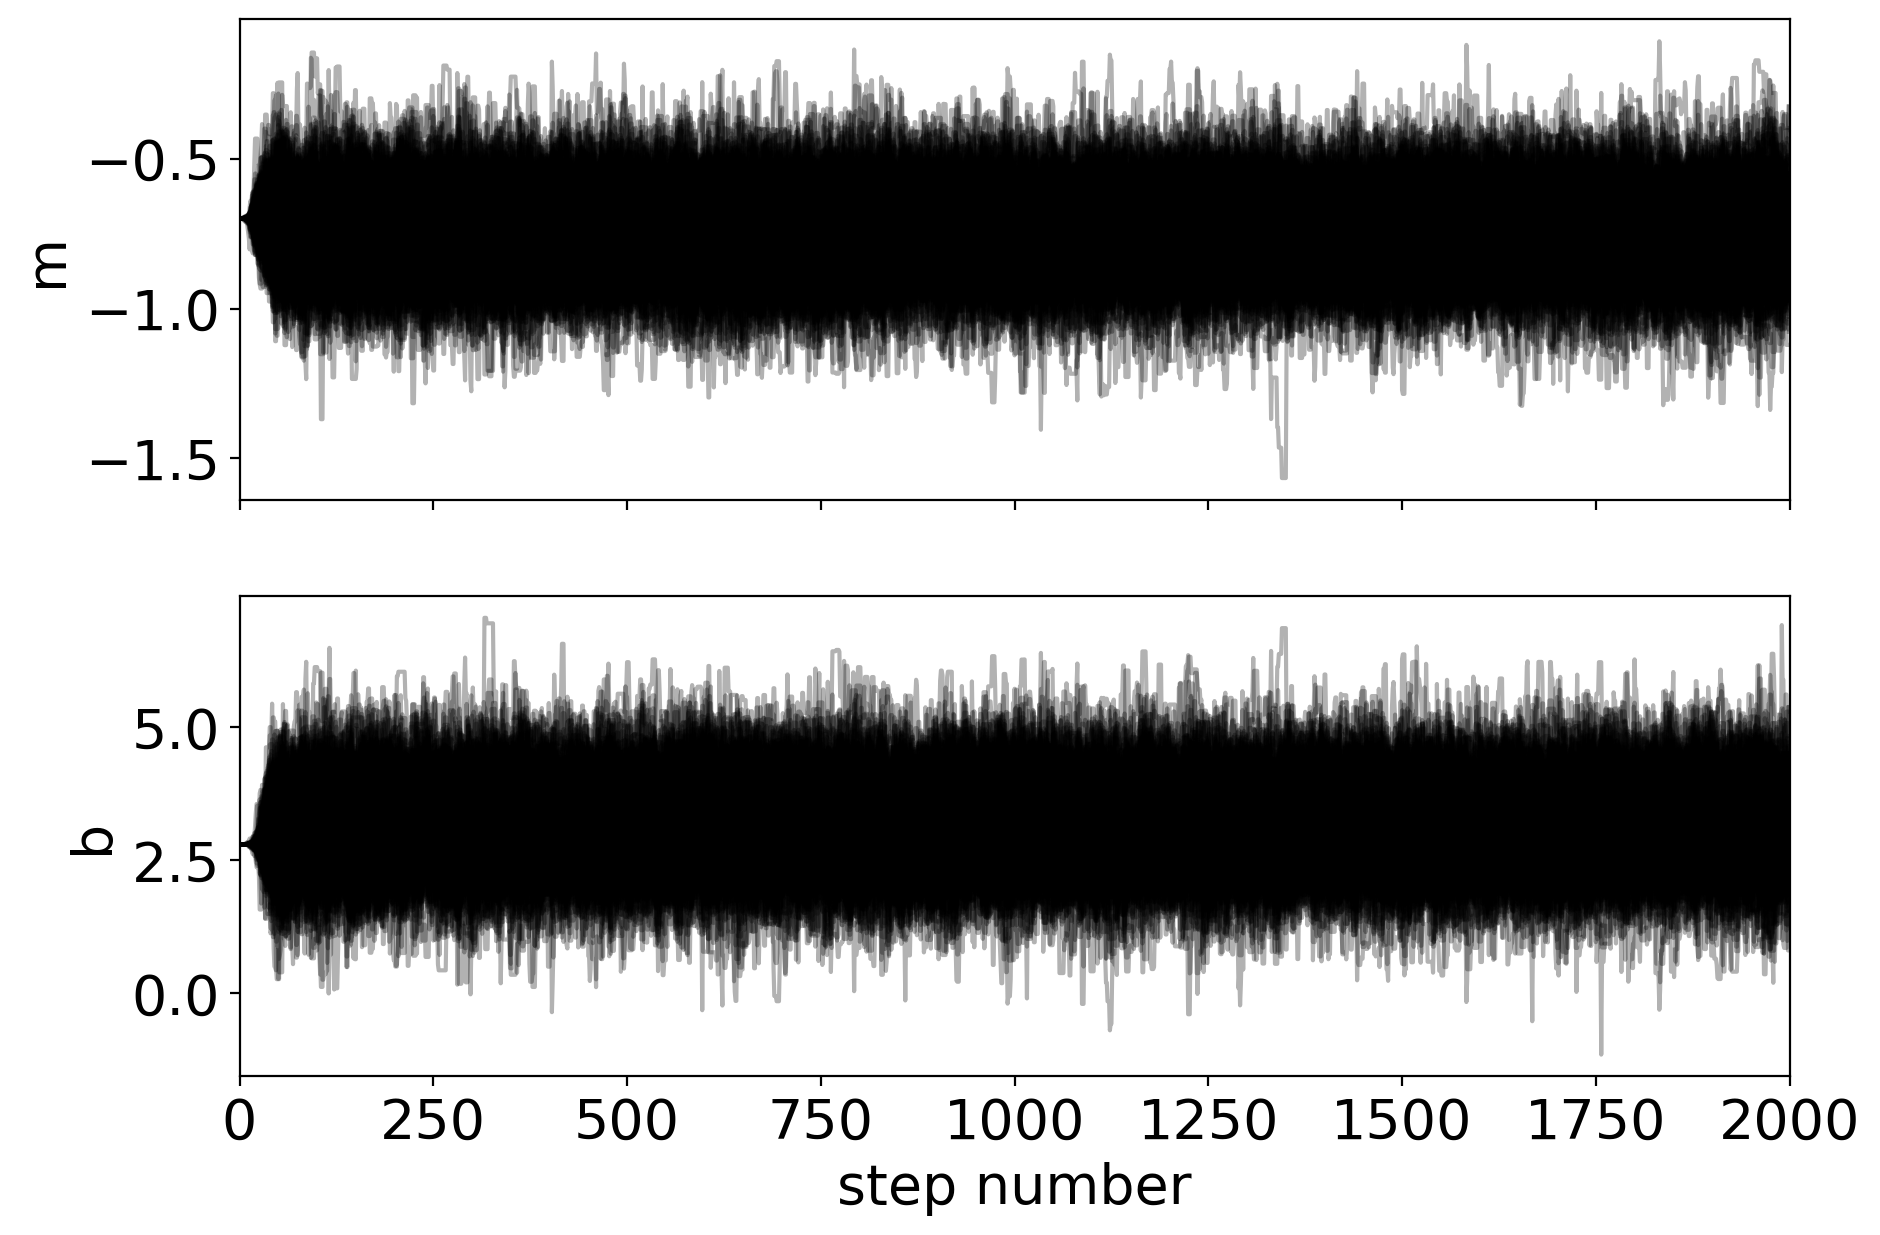

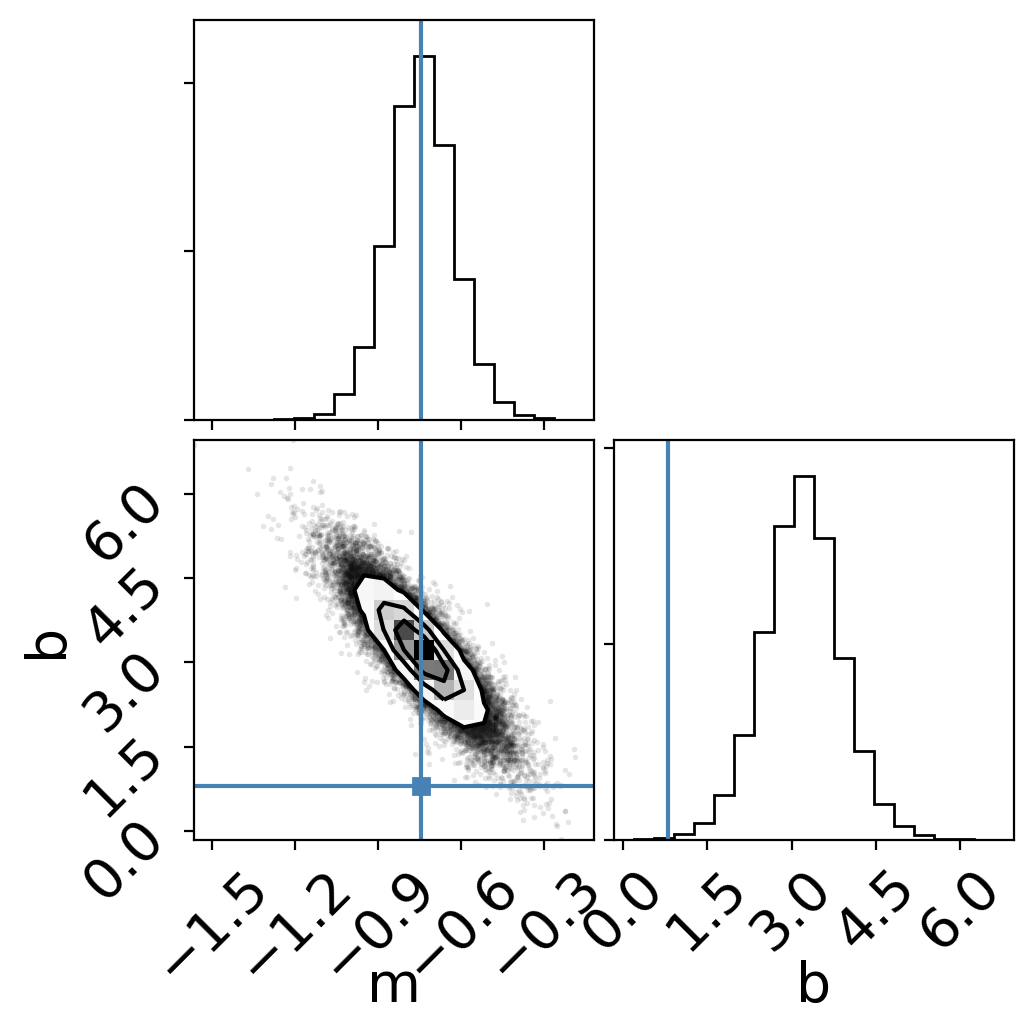

In [15]:
sampler = pid.run_mcmc(plot_show = True, debug = False)
truth_list, uncertainty_list = pid.plot_mcmc_results(sampler);

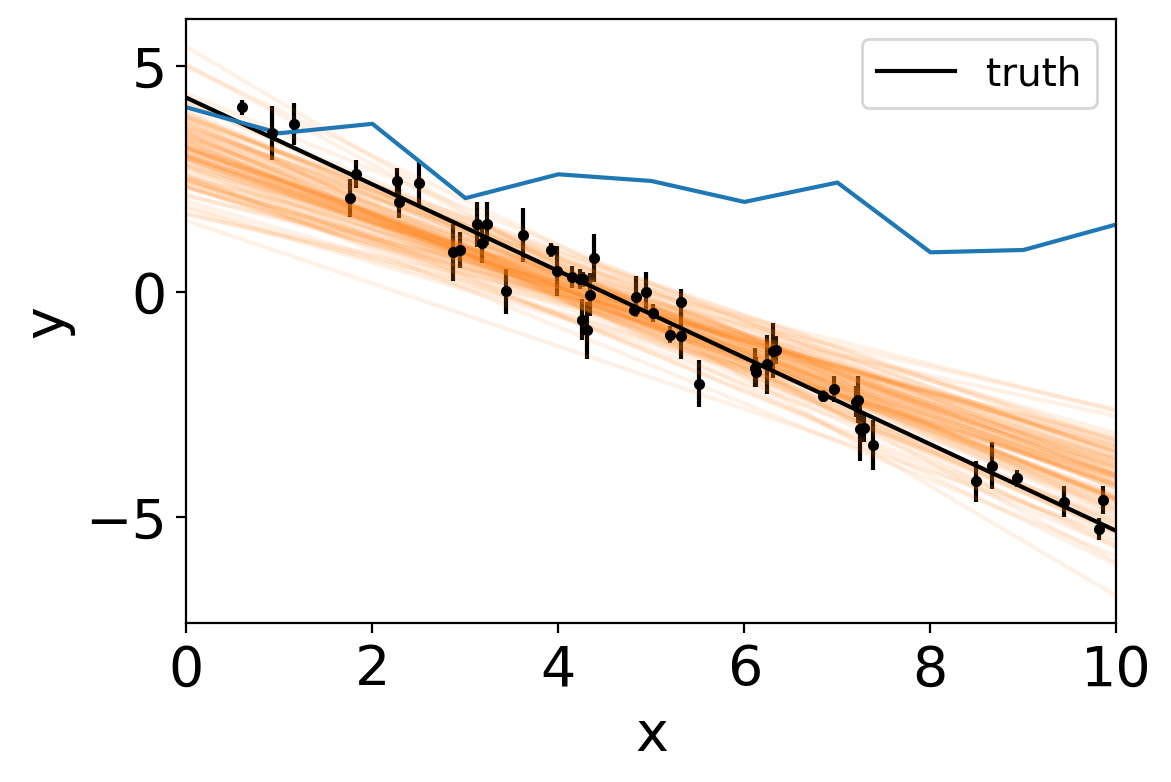

In [16]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.plot(y)
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [19]:
truth_list
uncertainty_list
pid.autocorrelation_time

array([28.53403527, 28.36940476])

In [9]:
# list(M.get_params())

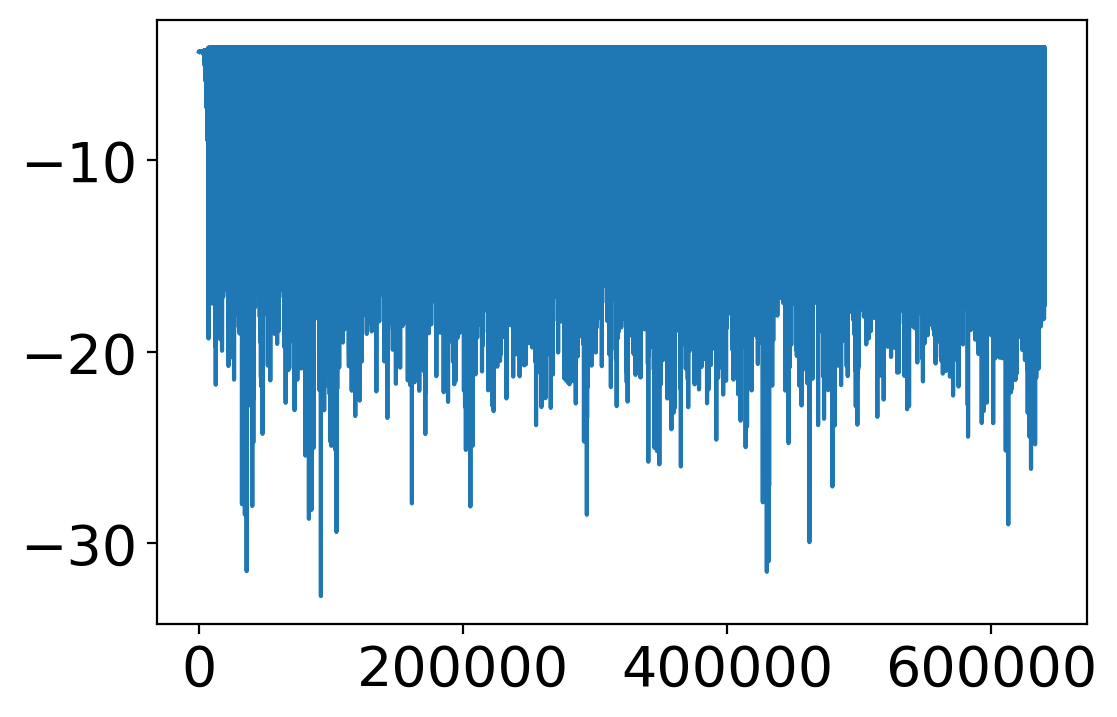

In [21]:

# rcParams['agg.path.chunksize'] = 10000
plt.close()
plt.figure()
plt.plot(pid.cost_progress)
plt.show()